In [161]:
import cv2
import dlib
import numpy as np
import imutils

from imutils import face_utils

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
import os, sys
import glob
import time
import warnings

# visualisation
import matplotlib.pyplot as plt

In [4]:
# define directories and path

prototxt = '../models/deploy.prototxt'
caffeModel = '../models/res10_300x300_ssd_iter_140000.caffemodel'

# data directories
data_raw = '../data/raw/'
data_processed = '../data/processed/'

### Utilities

In [5]:
IMAGETYPES = ('*.bmp', '*.png', '*.jpg', '*.jpeg', '*.tif') # Supported image types

In [6]:
def get_image_paths(file_root, pattern=None):
    """ Get ordered list of filepaths
    """
    file_paths = []
    for typ in IMAGETYPES:
        file_paths.extend(glob.glob(os.path.join(file_root,'**',typ), recursive=True))

    # filter filenames
    if pattern is not None:
        ffiltered = []
        ffiltered = [f for f in file_paths if pattern in os.path.split(f)[-1]]
        file_paths = ffiltered
        del ffiltered

    file_paths.sort()
    return file_paths

def load_face_dataset(file_root):
    """ Load all images and also list out the filepaths
    """
    if not os.path.isdir(file_root):
        raise FileNotFoundError("Face dataset file root: {} not found.".format(file_root))

    file_paths = get_image_paths(file_root)
    
    if len(file_paths) == 0:
        warnings.warn("No image found in face dataset file root: {}".format(file_root))
        return []
    
    images = [cv2.imread(file_path) for file_path in file_paths]
    return images, file_paths


def _pad_with_black(image):
    old_shape = image.shape[:2]
    target_size = max(old_shape)
    ratio = float(target_size) / max(old_shape)
    new_size = tuple([int(x * ratio) for x in old_shape])

    image = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = target_size - new_size[1]
    delta_h = target_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                      value=color)

    return padded_image

In [7]:
image = cv2.imread('../data/raw/gabriel/smile.jpg')

In [8]:
image.shape

(2021, 1515, 3)

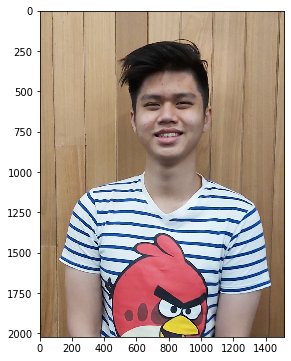

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(image[:,:,::-1]);

***
## Face Detector Model

This is the detector model class that acts as `sklearn.estimator` object. The reason so is because we intend to use `sklearn.pipeline` and `sklearn`'s model like `PCA` and `SVC` to train our embeddings and classifier.

The model simply unwraps the caffe models that has been pretrained before to detect and generate **bounding box** of face. We can use this bounding box to crop our face further.

One image may contain single face (e.g. training data) or multiple faces (e.g. live detection cam). Hence, we also provide arguments `single_face_mode` arguments to let the handler knows that we only need one face or many.

In [175]:
""" Definition for FaceDetector
"""

imageMean = [104.0, 177.0, 123.0]
confThresh = 0.5


class FaceDetector(BaseEstimator, TransformerMixin):
    """ Face dataset transformers that detect faces in an image and yield cropped faces image
    """

    def __init__(self, prototxt, caffeModel, imsize=(300,300), 
                 multiFaceMode=False, strict=False):
        """ Initialise face detector

        Args:
            .. prototxt   (str/path): path to prototxt file defining the architecture
            .. caffeModel (str/path): path to checkpoint file of pretrained caffe model
            .. imsize   (Tuple[int]): height and width of image blob
            .. multiFaceMode  (bool): whether to detect only multiple or single face for each image
            .. strict (bool) : if no face detected, raise error
        """
        if not os.path.isfile(prototxt):
            raise FileNotFoundError("Prototxt file: {} not found.".format(prototxt))
        
        if not os.path.isfile(caffeModel):
            raise FileNotFoundError("CaffeModel file: {} not found.".format(caffeModel))

        self.imsize = imsize
        self.multiFaceMode = multiFaceMode
        self.detector = cv2.dnn.readNetFromCaffe(prototxt, caffeModel=caffeModel)

    def fit(self, images=None):
        # unused but need to satisfy abstraction rule
        return self

    def transform(self, images):
        """ Perform face detection and cropping for batch of images
        
        Args:
            .. images (np.ndarray): array of images in tensor form of shape [C,H,W]

        Returns:
            .. faces (np.ndarray or List[List[np.ndarray]]): array of images in numpy tensor.
                    If multiFaceMode false, output is tensor of shape: [N,C,H,W]
                    If multiFaceMode true, output is array of cropped faces.
        """
        if self.multiFaceMode == True:
            faces = [self._detect_multi_faces(image) for image in images if image is not None]
        else:
            faces = np.stack([self._detect_single_face(image) for image in images])
        return faces

    def _detect_single_face(self, image):
        """ Apply detection assuming only one face per image
        
        Args:
            .. image (np.ndarray): images in numpy tensor form of shape [C,H,W]
        
        Returns:
            .. face (np.ndarray or None): image in numpy tensor of shape [C,H,W]. None if no face
        """
        h, w = image.shape[:2]

        # construct a blob from the image
        imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, self.imsize), 1.0, self.imsize, imageMean)

        # apply OpenCV's deep learning-based face detector to localize
        # faces in the input image
        self.detector.setInput(imageBlob)
        detections = self.detector.forward()
        
        # ensure at least one face was found
        if len(detections) > 0:
            # we're making the assumption that each image has only ONE
            # face, so find the bounding box with the largest probability
            i = np.argmax(detections[0, 0, :, 2])
            confidence = detections[0, 0, i, 2]

            # filter out weak detections
            if confidence > confThresh:
                # compute the (x, y)-coordinates of the bounding box for
                # the face
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # grab the ROI dimensions
                (fH, fW) = endY - startY, endX - startX

                # ensure the face width and height are sufficiently large
                if fW > 40 and fH > 40:
                    return dlib.rectangle(startX, startY, startX+fW, startY+fH)

        if strict:
            raise ValueError("Unable to detect face during FaceDetection in one of the image passed.\n"
                             "Ensure that image is clean and has face in it. "
                             "You can also \n increase the threshold.")
        return None
    
    def _detect_multi_faces(self, image):
        """ Apply detection assuming only one face per image
        
        Args:
            .. image (np.ndarray): images in numpy tensor form of shape [C,H,W]
        
        Returns:
            .. face_images (np.ndarray or None): array of faces images of shape 
        """
        blob = cv2.dnn.blobFromImage(cv2.resize(image, self.imsize, 1.0, self.imsize, imageMean))

        # apply OpenCV's deep learning-based face detector to localize
        # faces in the input image
        self.detector.setInput(imageBlob)
        detections = self.detector.forward()

        rects = []
        
        # loop over the detections
        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with
            # the prediction
            confidence = detections[0, 0, i, 2]

            # filter out weak detections with less than 50% confidence
            if confidence > 0.5:
                # compute the (x, y)-coordinates of the bounding box for
                # the face
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # grab the ROI dimensions
                (fH, fW) = endY - startY, endX - startX

                # ensure the face width and height are sufficiently large
                if fW < 40 or fH < 40:
                    continue

                rect = dlib.rectangle(startX, startY, startX+fW, startY+fH)
                rects.append(rect)

        return rects

In [151]:
# define file paths to model files
prototxt = '../models/deploy.prototxt'
caffeModel = '../models/res10_300x300_ssd_iter_140000.caffemodel'

In [197]:
# instantiate detector object
face_detector = FaceDetector(prototxt, caffeModel)

```
fit                  Returning self. Immediately use `fit_transform()` or `transform()`instead.
fit_transform        Fit to data, then transform it. Fits transformer to X and y with optiona
get_params           Get parameters for this estimator. Parameters ----------
set_params           Set the parameters of this estimator. The method works on simple estimat
transforms           Perform face detection and cropping for batch of images
```

#### Test FaceDetector

In [26]:
# loading test dataset
images, file_paths = load_face_dataset('../data/raw/')

In [27]:
len(images)

105

Testing `_detect_single_face()`

In [177]:
rects = detector.fit_transform(images)

In [178]:
len(rects)

105

In [179]:
rects.shape

(105,)

In [209]:
print("Number of faces:", len(faces))
print("Shape of a face:", faces[0].shape)

i = np.random.randint(0, len(rects)-1)
x, y, w, h = face_utils.rect_to_bb(rects[i])
x, y, w, h

Number of faces: 105
Shape of a face: (300, 300, 3)


ValueError: low >= high

In [207]:
i = 10

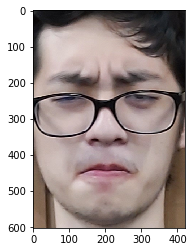

In [193]:
plt.imshow(images[i][y:y+h, x:x+w, ::-1]);

In [210]:
h, w = images[i].shape[:2]
rects = []

# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300,300)), 1.0, (300,300),
    imageMean, swapRB=False, crop=False)

# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
face_detector.detector.setInput(imageBlob)
detections = face_detector.detector.forward()

# loop over the detections
for ii in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the prediction
    confidence = detections[0, 0, ii, 2]

    # filter out weak detections with less than 50% confidence
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for
        # the face
        box = detections[0, 0, ii, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # grab the ROI dimensions
        (fH, fW) = endY - startY, endX - startX

        # ensure the face width and height are sufficiently large
        if fW < 40 or fH < 40:
            continue

        rect = dlib.rectangle(startX, startY, startX+fW, startY+fH)
        rects.append(rect)

In [211]:
rects

[rectangle(760,714,1311,1855)]

In [130]:
def rename_file_with_expression(filename):
    return filename.split('_')[-1]

### Saving FaceDetector results to disk

In [150]:
# save cropped face images to ../data/processed/cropped/
cropped_dir = '../data/processed/cropped/'

for face, file_path in zip(faces, file_paths):
    foldername = os.path.basename(os.path.dirname(file_path))
    filename = rename_file_with_expression(file_path)
    
    os.makedirs(os.path.join(cropped_dir, foldername), exist_ok=True)
    
    save_path = os.path.join(cropped_dir, foldername, filename)
    cv2.imwrite(save_path, face)

***
## Face Aligning

In [169]:
# install dlib from PyPi
!pip3 install dlib

  Cache entry deserialization failed, entry ignored


In [123]:
from imutils import face_utils


class FaceDetector(BaseEstimator, TransformerMixin):
    """ Face dataset transformer that detect faces in an image and yield cropped faces image.
    Optionally and when specified, it will also perform align faces by finding eyes horizon 
    line using dlib facial marking then rotate the image to make the horizon line to 0 degree.

    Works best with single face per input image.
    """
    
    def __init__(self, imsize=(300,300), face_landmark_model=None, desired_left_eye=(0.23, 0.23)):
        """ Initialise face aligner

        Args:
            .. face_landmark_model (str/path, optional): 
                    Optional, path to dlib predictor model for facial landmark.
                    If specified, then face alignment will be performed

            .. desired_left_eye (Tuple[float]): 
                    (x, y) tuple with the default shown, specifying the 
                    desired output left eye position
            
            .. imsize (Tuple[int]):
                    (height, width) tuple specifying desired output face image size
        """
        if not os.path.isfile(face_landmark_model):
            raise FileNotFoundError("Dlib facial landmark model (.dat) file: {} not found."
                                    .format(faceLandmarkModel))
        
        # define dlib dnn
        self.detector = dlib.get_frontal_face_detector()

        # set whether to perform face alignment
        self.do_face_alignment = face_landmark_model is not None
        self.predictor = dlib.shape_predictor(face_landmark_model) if face_landmark_model else None

        # image configurations
        self.desired_left_eye = desired_left_eye
        self.imsize = imsize

    # -----------------------
    # Transformer methods
    # -----------------------

    def fit(self, images):
        return self

    def transform(self, images):
        """ Perform face detection and cropping for batch of images
        
        Args:
            .. images (np.ndarray): array of images in tensor form of shape [H,W,C]

        Returns:
            .. faces (np.ndarray or List[List[np.ndarray]]): array of images in numpy tensor.
                    If multiFaceMode false, output is tensor of shape: [N,H,W,C]
                    If multiFaceMode true, output is array of cropped faces.
        """
        faces = [self._detect_single_face(image) for image in images]
        return faces

    # -----------------------
    # Face detector helpers
    # -----------------------

    def _detect_single_face(self, image):
        """ Apply detection assuming only one face per image
        
        Args:
            .. image (np.ndarray): images in numpy tensor form of shape [H,W,C]
        
        Returns:
            .. face (np.ndarray or None): image in numpy tensor of shape [H,W,C]. None if no face
        """
        desired_face_width, desired_face_height = self.imsize
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect face bounding box assuming single face
        rect = self.detector(gray, 1)[0]

        # if face alignment is specified then
        # perform face alignment and crop face from image
        if self.do_face_alignment:
            return self._align_face(image, rect)
        
        # otherwise, immediately crop face from the image
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        face = image[y:y+h, x:x+h]

        return face
        
    def _align_face(self, image, rect):
        """ Rotate and affine transformation to align face in the image to 0 degree.
        Args:
            .. image (np.ndarray): image face of shape [H,W,C]
            .. rect (dlib.rectangles): rect bounding box representation
        """

        # predict 5 facial landmarks coordinates and
        # convert the landmark (x, y) ~ coordinates to numpy array
        shape = self.predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # compute the center of mass for each eye
        left_eye_center = (shape[0] + shape[1]) / 2.0
        right_eye_center = (shape[2] + shape[3]) / 2.0

        # and compute the angle between the eye centroids
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dy, dx)) - 180
        
        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desired_right_eye_x = 1.0 - self.desired_left_eye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dx ** 2) + (dy ** 2))
        desired_dist = (desired_right_eye_x - self.desired_left_eye[0])
        desired_dist *= desired_face_width
        scale = desired_dist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                       (right_eye_center[1] + right_eye_center[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        rot_mat = cv2.getRotationMatrix2D(eyes_center, angle, scale)

        tx = desired_face_width * 0.5
        ty = desired_face_height * self.desired_left_eye[1]

        rot_mat[0, 2] += (tx - eyes_center[0])
        rot_mat[1, 2] += (ty - eyes_center[1])

        # apply the affine transformation
        (w, h) = (desired_face_width, desired_face_height)
        face = cv2.warpAffine(image, rot_mat, (w, h), flags=cv2.INTER_CUBIC)

        return face

In [57]:
# define file path to model files
faceLandmarkModel = "../models/shape_predictor_5_face_landmarks.dat"

In [124]:
face_detector = FaceDetectorAligner(faceLandmarkModel, (0.225, 0.225))

#### Test Face Aligners and Annotators

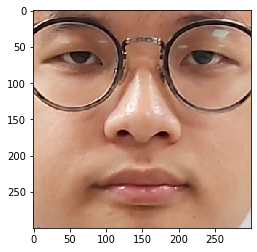

In [141]:
i = np.random.randint(0, len(images)-1)
face = face_detector._detect_single_face(images[i])

plt.imshow(face[:,:,::-1]);

In [125]:
# loading test dataset
images, file_paths = load_face_dataset('../data/raw/')

In [126]:
faces = face_detector.fit_transform(images)

In [127]:
len(images)

105

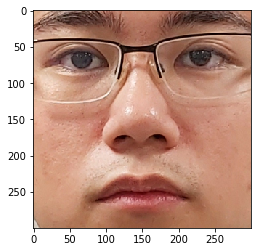

In [139]:
i = np.random.randint(0, len(images)-1)
plt.imshow(faces[20][:,:,::-1]);

In [137]:
cv2.imwrite("sample.jpg", faces[i])

True

### Saving results to disk

In [131]:
def rename_file_with_expression(filename):
    return filename.split('_')[-1]

In [140]:
# save cropped face images to ../data/processed/cropped/
cropped_dir = '../data/processed/cropped/'

for face, file_path in zip(faces, file_paths):
    foldername = os.path.basename(os.path.dirname(file_path))
    filename = rename_file_with_expression(file_path)
    
    os.makedirs(os.path.join(cropped_dir, foldername), exist_ok=True)
    save_path = os.path.join(cropped_dir, foldername, filename)
    success = cv2.imwrite(save_path, face)
    if not success:
        print("Unsuccessful when saving image {} to {}".format(face.shape, save_path))